# Combine multiple same label images

In [1]:
import pandas as pd
import numpy as np
import tensorflow
from tensorflow import keras
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import matplotlib.pyplot as plt

![combining 2 images](https://techblog.cdiscount.com/assets/images/DataScience/feedback_kaggle/1st_img_better_480.png)  
![combining 4 images](https://techblog.cdiscount.com/assets/images/DataScience/feedback_kaggle/differents_envs.png)  
![combining 3 images](https://techblog.cdiscount.com/assets/images/DataScience/feedback_kaggle/differents_angles.png)

In [2]:
!mkdir ./shopee_augmented_data 
!mkdir ./shopee_augmented_data/train_images
!cp -r ../input/shopee-product-matching/test_images ./shopee_augmented_data/test_images

In [3]:
original_train_df = pd.read_csv('../input/shopee-product-matching/train.csv')
train_df = original_train_df.copy()
value_count_dict ={}
for count, label in zip(train_df['label_group'].value_counts().to_list(), train_df['label_group'].value_counts().index.to_list()):
    value_count_dict[label]=count     
    
train_df['label_count'] = train_df['label_group']
train_df['label_count'].replace(value_count_dict, inplace=True)
display(train_df.head())

train_df['image'] = train_df['label_group'].map(lambda x: 'simple_2pair_'+str(x)+'.jpg')
train_df['posting_id'] = train_df['posting_id'].map(lambda x: 'posting_id')
train_df['image_phash'] = train_df['image_phash'].map(lambda x: 'image_phash')
train_df['title'] = train_df['title'].map(lambda x: 'title')

train_df2 = train_df.copy()
train_df2['image'] = train_df2['label_group'].map(lambda x: 'processed_2pair_'+str(x)+'.jpg')
train_df2['posting_id'] = train_df2['posting_id'].map(lambda x: 'posting_id')
train_df2['image_phash'] = train_df2['image_phash'].map(lambda x: 'image_phash')
train_df2['title'] = train_df2['title'].map(lambda x: 'title')

train_output_df = pd.concat([train_df, train_df2], axis=0)
train_output_df = train_output_df[train_output_df['label_count']==2].drop_duplicates().drop('label_count', axis=1)
display(train_output_df.shape)
display(train_output_df.head())
train_output_df.to_csv('./shopee_augmented_data/train.csv', index=False)

,posting_id,image,image_phash,title,label_group,label_count
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,2
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,2
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,2
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,2
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,2


(13958, 5)

,posting_id,image,image_phash,title,label_group
0,posting_id,simple_2pair_249114794.jpg,image_phash,title,249114794
1,posting_id,simple_2pair_2937985045.jpg,image_phash,title,2937985045
2,posting_id,simple_2pair_2395904891.jpg,image_phash,title,2395904891
3,posting_id,simple_2pair_4093212188.jpg,image_phash,title,4093212188
4,posting_id,simple_2pair_3648931069.jpg,image_phash,title,3648931069


In [4]:
test_df = pd.read_csv('../input/shopee-product-matching/test.csv')
test_df.to_csv('./shopee_augmented_data/test.csv', index=False)

In [5]:
datagen = ImageDataGenerator(
           rotation_range=20,
           width_shift_range=0.2,
           height_shift_range=0.2,
           #shear_range=0.2,
           zoom_range=0.2,
           horizontal_flip=True,
           vertical_flip=False,
           fill_mode='nearest')

def simple_augment(img_name, train=True):
    input_path = '../input/shopee-product-matching/train_images/'+img_name if train else '../input/shopee-product-matching/test_images/'+img_name
    img = keras.preprocessing.image.load_img(input_path)
    x = keras.preprocessing.image.img_to_array(img)
    x = x.reshape((1,) + x.shape)
    
    g = datagen.flow(x, batch_size=1)
    g = np.squeeze(g[0])
    img = keras.preprocessing.image.array_to_img(g, scale=True)
    return img


def get_2img_concat_h_resize(im1, im2, resample=Image.BICUBIC, resize_big_image=True):
    if im1.height == im2.height:
        _im1 = im1
        _im2 = im2
    elif (((im1.height > im2.height) and resize_big_image) or
          ((im1.height < im2.height) and not resize_big_image)):
        _im1 = im1.resize((int(im1.width * im2.height / im1.height), im2.height), resample=resample)
        _im2 = im2
    else:
        _im1 = im1
        _im2 = im2.resize((int(im2.width * im1.height / im2.height), im1.height), resample=resample)
    dst = Image.new('RGB', (_im1.width + _im2.width, _im1.height))
    dst.paste(_im1, (0, 0))
    dst.paste(_im2, (_im1.width, 0))
    return dst


In [6]:
# train:2枚を単に連結
for label in tqdm(train_df2[train_df2['label_count']==2]['label_group'].unique()):
    img_names = original_train_df[original_train_df['label_group']==label]['image'].to_list()
    img_name1 = img_names[0]
    img_name2 = img_names[1]
    img1 = keras.preprocessing.image.load_img('../input/shopee-product-matching/train_images/'+img_name1)
    img2 = keras.preprocessing.image.load_img('../input/shopee-product-matching/train_images/'+img_name2)
    get_2img_concat_h_resize(img1, img2).save('./shopee_augmented_data/train_images/'+'simple_2pair_'+str(label)+'.jpg')

# train:2枚を加工後連結
for label in tqdm(train_df[train_df['label_count']==2]['label_group'].unique()):
    img_names = original_train_df[original_train_df['label_group']==label]['image'].to_list()
    img_name1 = img_names[1]
    img_name2 = img_names[0]
    img1 = simple_augment(img_name1, train=True)
    img2 = simple_augment(img_name2, train=True)
    get_2img_concat_h_resize(img1, img2).save('./shopee_augmented_data/train_images/'+'processed_2pair_'+str(label)+'.jpg')

100%|██████████| 6979/6979 [42:16<00:00,  2.75it/s]


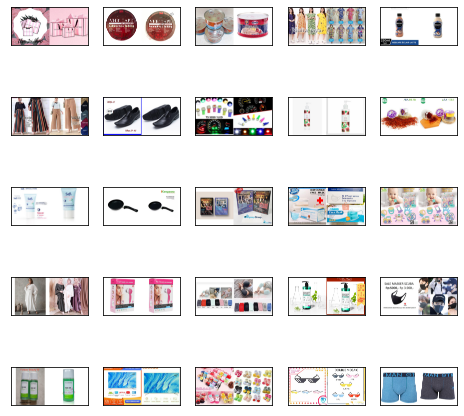

In [7]:
# 出力画像を表示してみる
n_data = 25 # 表示するデータ数
row=5 # 行数
col=5 # 列数
fig, ax = plt.subplots(nrows=row, ncols=col,figsize=(8,8))

for i, img_name in enumerate(train_output_df['image'].to_list()[:25]):
    filename = './shopee_augmented_data/train_images/'+img_name
    img = Image.open(filename, 'r')  # 画像読み込み
    _r= i//col
    _c= i%col
    ax[_r,_c].axes.xaxis.set_visible(False) # X軸を非表示に
    ax[_r,_c].axes.yaxis.set_visible(False) # Y軸を非表示に
    ax[_r,_c].imshow(np.array(img))

In [8]:
!zip -r shopee_augmented_data.zip shopee_augmented_data
!rm -rf shopee_augmented_data

  adding: shopee_augmented_data/ (stored 0%)
  adding: shopee_augmented_data/train.csv (deflated 86%)
  adding: shopee_augmented_data/test.csv (deflated 25%)
  adding: shopee_augmented_data/train_images/ (stored 0%)
  adding: shopee_augmented_data/train_images/processed_2pair_2213666210.jpg (deflated 1%)
  adding: shopee_augmented_data/train_images/simple_2pair_1248171988.jpg (deflated 7%)
  adding: shopee_augmented_data/train_images/processed_2pair_1459401360.jpg (deflated 18%)
  adding: shopee_augmented_data/train_images/simple_2pair_2570143988.jpg (deflated 4%)
  adding: shopee_augmented_data/train_images/simple_2pair_2149136762.jpg (deflated 11%)
  adding: shopee_augmented_data/train_images/processed_2pair_3414534045.jpg (deflated 10%)
  adding: shopee_augmented_data/train_images/simple_2pair_2257604078.jpg (deflated 11%)
  adding: shopee_augmented_data/train_images/processed_2pair_2843273332.jpg (deflated 2%)
  adding: shopee_augmented_data/train_images/simple_2pair_2151845003.jpg